In [1]:
# Data source: https://www.kaggle.com/datasets/andersra/sales-data-from-a-rental-company

# Import libraries and set up databases:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3 as sl

# Import all 6 csvs as individual dataframes:
aerator_df = pd.read_csv('Aerator.csv')
dehum_df = pd.read_csv('Dehumidifier.csv')
forklift_df = pd.read_csv('Forklift.csv')
heater_df = pd.read_csv('Heater.csv')
minid_df = pd.read_csv('Mini dumper.csv')
pipe_df = pd.read_csv('Pipe pressing machine.csv')

# Let's take a look at the first 5 rows of the first dataframe:
aerator_df.head()
# So there are 6 columns. Kaggle tells us that each csv represents a different type of item, 
# and the product IDs represent variations of that item (height, brand, etc).


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID
0,100001093,2008-06-09 08:29:14.4530000,2008-06-08 22:00:00.0000000,2008-06-09 21:59:59.0000000,43,165137
1,100001093,2008-05-17 10:49:31.3270000,2008-05-16 22:00:00.0000000,2008-05-17 21:59:59.0000000,43,64659
2,100001093,2008-05-15 08:38:37.6100000,2008-05-14 22:00:00.0000000,2008-05-15 21:59:59.0000000,43,162629
3,100001093,2008-04-07 06:34:40.9830000,2008-04-06 22:00:00.0000000,2008-04-07 21:59:59.0000000,43,64482
4,100001093,2008-04-08 14:19:58.5930000,2008-04-08 22:00:00.0000000,2008-04-09 21:59:59.0000000,43,158672


In [2]:
# Let's begin poking around. Are we missing any values?
all_dfs = [aerator_df, dehum_df, forklift_df, heater_df, minid_df, pipe_df]

for df in all_dfs:
    print(df.info())
    
# No missing values!
# These dataframes are consistent in structure, with the most entries for pipe pressing machines, 
# and the least for aerators.
# The three int fields are all IDs, and the three object fields are datetimes.
# We'll have to convert those objects to actual datetimes to do anything interesting with them.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product ID     1368 non-null   int64 
 1   Order created  1368 non-null   object
 2   Rental start   1368 non-null   object
 3   Rental end     1368 non-null   object
 4   Vendor ID      1368 non-null   int64 
 5   Customer ID    1368 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 64.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7780 entries, 0 to 7779
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product ID     7780 non-null   int64 
 1   Order created  7780 non-null   object
 2   Rental start   7780 non-null   object
 3   Rental end     7780 non-null   object
 4   Vendor ID      7780 non-null   int64 
 5   Customer ID    7780 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 36

In [3]:
# There's no missing data, nothing looks like unnecessary data, so let's look for outliers.
# Since all of our int values are IDs, there won't really be any outliers in that data.
# Let's make a column in each dataframe for duration, which is where we may see some outliers.

#First, we'll ensure that those columns are in datetime format.
for df in all_dfs:
    df[('Rental end')] = pd.to_datetime(df[('Rental end')])
    df[('Rental start')] = pd.to_datetime(df[('Rental start')])
    df['duration'] = (df['Rental end'] - df['Rental start']) / np.timedelta64(1, 'D')
    print(df.describe())


         Product ID    Vendor ID   Customer ID     duration
count  1.368000e+03  1368.000000  1.368000e+03  1368.000000
mean   1.000066e+08    56.879386  3.448185e+05     1.157731
std    4.706917e+03    73.635667  4.496959e+05     0.734700
min    1.000011e+08     2.000000  2.830000e+02     0.958322
25%    1.000011e+08     9.000000  7.864350e+04     0.999988
50%    1.000078e+08    39.000000  1.781490e+05     0.999988
75%    1.000106e+08    43.000000  3.434485e+05     0.999988
max    1.000173e+08   285.000000  1.519737e+06    15.999988
         Product ID    Vendor ID   Customer ID     duration
count  7.780000e+03  7780.000000  7.780000e+03  7780.000000
mean   1.000075e+08    54.296787  2.943176e+05    26.242641
std    4.473501e+03    87.424306  4.434561e+05    40.955325
min    1.000002e+08     2.000000  1.500000e+01     0.999988
25%    1.000070e+08     2.000000  1.282000e+03     4.999988
50%    1.000091e+08     8.000000  1.058470e+05    12.999988
75%    1.000091e+08    63.000000  3.0014

In [4]:
# Ok, it looks like there might be some outliers. The max value for duration seems to be significantly higher than
# the 75th percentile for every product group.
# Some of those std numbers are bonkers (671?!?).
# And the minimum value for pipe pressing machines is a negative number, so that's got to be a typo!
# I'll start by investigating that negative number. 
# Let's look at the bottom 5 values for duration for renting pipe pressing machines.
pipe_df.sort_values(by="duration").head()


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
646,100008514,2008-03-26 09:51:30.2800000,2008-03-26 23:00:00,2008-03-26 22:59:59,75,96022,-0.000012
4601,100008749,2020-01-16 11:35:34.9514312,2020-01-15 23:00:00,2020-01-16 22:59:59,77,1354741,0.999988
5440,100008749,2018-01-26 06:22:52.1352428,2018-01-25 23:00:00,2018-01-26 22:59:59,125,311283,0.999988
5439,100008749,2018-01-25 10:54:41.2577970,2018-01-24 23:00:00,2018-01-25 22:59:59,92,139588,0.999988
10642,100008811,2013-07-01 06:14:56.3200000,2013-06-30 22:00:00,2013-07-01 21:59:59,120,156944,0.999988


In [5]:
# While we're here, let's look at the upper end of duration for pipe pressing machines.
pipe_df.sort_values(by="duration").tail(20)


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
11280,100009650,2019-03-29 14:04:44.5195587,2019-02-28 23:00:00,2020-12-11 22:59:59,226,1438974,651.999988
6769,100008749,2019-03-29 14:04:44.5195587,2019-02-28 23:00:00,2020-12-11 22:59:59,226,1438974,651.999988
11318,100009650,2016-10-26 12:39:50.2000027,2016-10-03 22:00:00,2019-06-28 21:59:59,124,358951,997.999988
11319,100009650,2016-10-26 12:39:50.2000027,2016-10-03 22:00:00,2019-06-28 21:59:59,124,358951,997.999988
11853,100015908,2019-11-20 11:40:10.8475594,2018-10-31 23:00:00,2021-10-30 21:59:59,226,1436926,1094.958322
11430,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988
11281,100009650,2019-03-05 07:10:03.6421374,2019-03-06 23:00:00,2022-03-05 22:59:59,226,1433034,1094.999988
11283,100009650,2019-01-30 14:00:35.1420862,2019-01-08 23:00:00,2022-01-07 22:59:59,226,1433034,1094.999988
11433,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988
11432,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988


In [6]:
# Ok, couldn't help but notice that some of those rentals ended in 2099. Let's drop them!
pipe_df = pipe_df.loc[pipe_df['duration'] < 20000]
pipe_df.sort_values(by='duration').tail()
# Much better.


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
11283,100009650,2019-01-30 14:00:35.1420862,2019-01-08 23:00:00,2022-01-07 22:59:59,226,1433034,1094.999988
11433,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988
11437,100012123,2014-02-27 12:58:13.1230000,2014-02-26 23:00:00,2017-07-12 21:59:59,195,292934,1231.958322
11429,100010692,2014-04-22 08:49:54.0330000,2014-04-21 22:00:00,2017-09-13 21:59:59,50,242843,1240.999988
11438,100012123,2014-06-13 10:03:18.9870000,2014-06-12 22:00:00,2019-11-05 22:59:59,195,293013,1972.041655


In [7]:
# Now it's time to remove the other obvious (negative) outlier.
pipe_df = pipe_df.loc[pipe_df['duration'] > 0]
pipe_df.sort_values(by="duration").head()
# Success!


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
6112,100008749,2015-02-20 08:03:53.4216652,2015-02-19 23:00:00,2015-02-20 22:59:59,166,330781,0.999988
5440,100008749,2018-01-26 06:22:52.1352428,2018-01-25 23:00:00,2018-01-26 22:59:59,125,311283,0.999988
5439,100008749,2018-01-25 10:54:41.2577970,2018-01-24 23:00:00,2018-01-25 22:59:59,92,139588,0.999988
10642,100008811,2013-07-01 06:14:56.3200000,2013-06-30 22:00:00,2013-07-01 21:59:59,120,156944,0.999988
5437,100008749,2018-01-25 13:10:23.9526252,2018-01-24 23:00:00,2018-01-25 22:59:59,77,292392,0.999988


In [8]:
# Let's dig deeper into the aerator df.
# aerator_df.sort_values(by="duration").head()
aerator_df.sort_values(by="duration").tail()

# The 15 day rental is an outlier, but it's still informative, and I don't think it's a typo.


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
1255,100012881,2016-06-28 05:24:57.4549199,2016-06-27 22:00:00,2016-07-04 21:59:59,2,313843,6.999988
80,100001095,2019-03-23 12:13:28.4050597,2019-03-22 23:00:00,2019-03-29 22:59:59,78,1401179,6.999988
1214,100012519,2018-04-05 12:58:32.7867131,2018-04-05 22:00:00,2018-04-13 21:59:59,74,298838,7.999988
859,100007805,2019-03-21 10:09:09.0681735,2019-03-31 22:00:00,2019-04-08 21:59:59,9,95189,7.999988
1326,100014496,2019-08-01 09:02:52.5007480,2019-07-31 22:00:00,2019-08-16 21:59:59,251,1346791,15.999988


In [9]:
# Now we'll look at dehumidifiers.
# dehum_df.sort_values(by="duration").head()
dehum_df.sort_values(by="duration").tail(20)

# Whoa! People rent dehumidifiers for a long time! Let's keep all of these.


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
4206,100009100,2015-06-16 06:01:47.5267982,2015-06-15 22:00:00,2016-04-30 21:59:59,74,239737,319.999988
1015,100000192,2007-07-17 09:04:41.3270000,2007-07-14 22:00:00,2008-05-30 21:59:59,39,28956,320.999988
3441,100007871,2007-06-16 13:53:32.8430000,2007-06-15 22:00:00,2008-05-16 21:59:59,2,921,335.999988
2917,100007871,2007-01-21 17:58:00.9530000,2007-01-20 23:00:00,2008-01-08 22:59:59,2,921,352.999988
99,100000183,2008-04-01 08:56:56.4830000,2008-03-31 22:00:00,2009-04-01 21:59:59,50,51830,365.999988
1510,100000195,2008-02-18 10:25:38.5630000,2008-02-17 23:00:00,2009-03-06 22:59:59,50,119355,382.999988
36,100000183,2008-02-18 10:48:15.9530000,2008-02-17 23:00:00,2009-03-06 22:59:59,50,119360,382.999988
4871,100009100,2008-08-05 08:47:19.1570000,2008-08-04 22:00:00,2009-09-02 21:59:59,2,157,393.999988
3751,100008847,2009-08-12 05:56:08.7070000,2009-08-11 22:00:00,2010-09-23 21:59:59,114,149829,407.999988
176,100000184,2012-04-02 13:08:58.2730000,2012-04-01 22:00:00,2013-06-04 21:59:59,50,161352,428.999988


<AxesSubplot:xlabel='duration', ylabel='Count'>

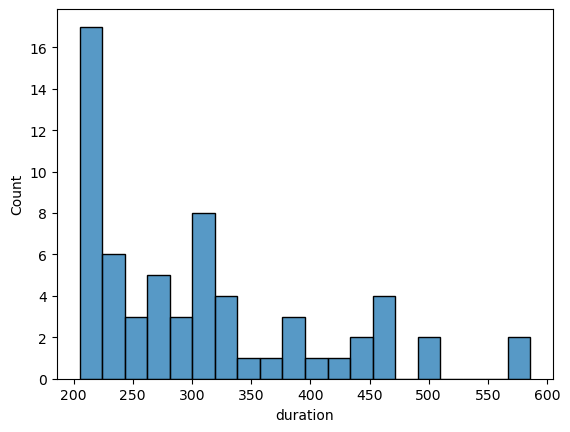

In [10]:
# Let's create a histogram of the upper half of dehumidifier rentals to look at the distribution.
# Looking at the data above, the middle-most duration was about 13 days.

# top_dehum = dehum_df.loc[dehum_df['duration'] > 13]

# Looks like most of them are still below 50-day rentals. Let's look at the over 200-day rentals.
top_dehum = dehum_df.loc[dehum_df['duration'] > 200]

# Still quite a few!
sns.histplot(data=top_dehum, x='duration', bins=20)


In [11]:
# There are 2 values that have a duration over 550 days. Let's look at them.
top_dehum = dehum_df.loc[dehum_df['duration'] > 550]
top_dehum.head()

# Same vendor, different customers, same start and end times, and the order creation differs by about an hour.
# I wonder if this was an order where the vendor added the wrong Customer ID and went back an hour later to fix it.
# Either way, let's drop both of these, since they're outliers and they seem too suspicious to trust.
dehum_df = dehum_df.loc[dehum_df['duration'] < 550]
dehum_df.sort_values(by="duration").tail()


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
3435,100007871,2009-06-25 11:45:25.5170000,2009-06-24 22:00:00,2010-10-06 21:59:59,2,598,468.999988
3012,100007871,2009-06-25 11:45:25.5170000,2009-06-24 22:00:00,2010-10-06 21:59:59,2,598,468.999988
2897,100007871,2009-06-25 11:45:25.5170000,2009-06-24 22:00:00,2010-10-06 21:59:59,2,598,468.999988
1575,100000200,2006-05-10 09:39:07.7330000,2006-09-26 22:00:00,2008-02-08 22:59:59,50,80688,500.041655
260,100000184,2006-05-10 09:39:07.7330000,2006-09-26 22:00:00,2008-02-08 22:59:59,50,80688,500.041655


In [12]:
# Next, we'll look at forklifts.
# forklift_df.sort_values(by="duration").head()
forklift_df.sort_values(by="duration").tail(20)

# We've got one obvious outlier, but looking at the outliers for the previous groups, Customer ID #50 tends to
# rent things for while! I think we should drop it since it's one value and it's over twice the next largest value.
# This will make our analysis more cogent.


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
992,100001596,2019-02-08 11:31:48.1721344,2019-02-10 23:00:00,2019-08-31 21:59:59,248,194,201.958322
2681,100011991,2017-10-25 12:04:41.8121382,2017-10-25 22:00:00,2018-05-17 21:59:59,248,360286,203.999988
3714,100014485,2019-03-26 15:09:59.0859442,2019-03-26 23:00:00,2019-10-28 22:59:59,246,498489,215.999988
836,100001591,2015-11-23 06:26:19.5277384,2015-12-15 23:00:00,2016-07-21 21:59:59,2,655,218.958322
3,100001139,2011-02-23 10:39:24.4070000,2011-08-07 22:00:00,2012-03-13 22:59:59,144,184514,219.041655
4267,100014483,2019-03-18 08:19:14.6515270,2019-03-17 23:00:00,2019-10-28 22:59:59,246,498489,224.999988
4207,100014483,2019-03-14 08:19:18.1473646,2019-03-17 23:00:00,2019-10-30 22:59:59,249,498489,226.999988
4186,100014483,2019-04-23 08:06:07.7630129,2019-04-30 22:00:00,2019-12-13 22:59:59,246,1006606,227.041655
1581,100011991,2017-05-16 10:06:06.2411200,2017-05-16 22:00:00,2018-01-16 22:59:59,248,360286,245.041655
353,100001149,2018-04-23 10:14:42.3033390,2018-04-22 22:00:00,2019-01-07 22:59:59,50,1405964,260.041655


In [13]:
# Dropping the outlier in the forklift dataframe.
forklift_df = forklift_df.loc[forklift_df['duration'] < 1000]
forklift_df.sort_values(by='duration').tail()


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
1220,100001596,2020-01-17 07:28:54.2760750,2019-12-31 23:00:00,2020-12-30 22:59:59,226,1429866,364.999988
940,100001596,2020-01-22 12:28:12.8821369,2019-12-31 23:00:00,2021-01-20 22:59:59,226,1429866,385.999988
4266,100014483,2019-11-08 12:17:37.6835758,2019-11-11 23:00:00,2020-12-31 22:59:59,255,557517,415.999988
567,100001150,2010-01-14 07:40:17.4670000,2009-12-31 23:00:00,2011-03-23 22:59:59,39,188367,446.999988
2585,100011991,2019-01-08 08:33:28.5530662,2018-10-31 23:00:00,2020-02-06 22:59:59,2,1440228,462.999988


In [14]:
# Halfway done! Let's look at heaters now.
# heater_df.sort_values(by="duration").head()
heater_df.sort_values(by="duration").tail(20)

# Ok, that's an enormous outlier. And my theory that it's all Customer #50 is shot. 
# These guys rented a heater for 6 years! It's so much longer than the others in this set, so I'll drop it.


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
3704,100000545,2014-03-06 13:36:00.2030000,2014-03-05 23:00:00,2014-12-15 22:59:59,143,185219,284.999988
3705,100000545,2014-03-06 13:36:00.2030000,2014-03-05 23:00:00,2014-12-15 22:59:59,143,185219,284.999988
3589,100000540,2010-03-18 10:28:47.1800000,2009-12-31 23:00:00,2010-11-05 22:59:59,143,185226,308.999988
4393,100010431,2014-03-06 13:36:00.2030000,2014-03-05 23:00:00,2015-02-09 22:59:59,143,185219,340.999988
4763,100011315,2018-07-26 08:57:13.7270452,2019-01-09 23:00:00,2019-12-19 22:59:59,143,1427753,343.999988
3703,100000545,2011-11-09 08:19:57.7600000,2011-10-03 22:00:00,2012-10-01 21:59:59,143,185200,363.999988
853,100000525,2008-03-03 09:04:07.3270000,2008-03-06 23:00:00,2009-03-06 22:59:59,50,120320,364.999988
3614,100000540,2010-03-23 08:28:05.2270000,2010-01-31 23:00:00,2011-02-08 22:59:59,143,185226,372.999988
1966,100000525,2014-03-19 11:17:39.5500000,2014-03-18 23:00:00,2015-04-01 21:59:59,50,37471,378.958322
2467,100000529,2009-11-05 11:45:19.5200000,2009-11-04 23:00:00,2010-12-09 22:59:59,2,617,399.999988


In [15]:
# Dropping the outlier in the heater dataframe.
heater_df = heater_df.loc[heater_df['duration'] < 1000]
heater_df.sort_values(by='duration').tail()


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
724,100000525,2007-09-26 09:11:59.0630000,2007-09-25 22:00:00,2008-12-31 22:59:59,2,465,463.041655
3751,100000545,2010-03-15 09:24:33.4600000,2009-12-31 23:00:00,2011-04-20 21:59:59,143,185200,474.958322
4366,100010431,2016-02-08 12:21:48.1698677,2016-11-29 23:00:00,2018-07-20 21:59:59,143,352123,597.958322
4665,100011605,2016-02-08 12:21:48.1698677,2016-11-29 23:00:00,2018-07-20 21:59:59,143,352123,597.958322
3949,100008087,2017-01-03 07:03:51.2981851,2017-01-05 23:00:00,2018-10-26 21:59:59,143,363363,658.958322


In [16]:
# On to the minidumps
# minid_df.sort_values(by="duration").head()
minid_df.sort_values(by="duration").tail(20)

# Those outliers aren't too crazy. We'll keep them.
# That's it for outliers!


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration
1938,100007824,2019-05-23 06:22:49.0558904,2019-05-22 22:00:00,2019-07-06 21:59:59,246,479449,44.999988
1906,100007824,2019-06-05 09:03:48.8409233,2019-07-21 22:00:00,2019-09-04 21:59:59,256,1366614,44.999988
2541,100015122,2018-09-03 11:39:22.8697940,2018-09-02 22:00:00,2018-10-18 21:59:59,256,1346797,45.999988
1563,100007824,2018-09-20 11:42:42.0801952,2018-09-19 22:00:00,2018-11-06 22:59:59,249,1421871,48.041655
1529,100007824,2018-07-18 08:37:58.0161336,2018-07-17 22:00:00,2018-09-06 21:59:59,246,1421648,50.999988
632,100006996,2017-06-14 06:23:22.0876235,2017-06-13 22:00:00,2017-08-04 21:59:59,8,291049,51.999988
224,100001275,2010-05-11 10:59:38.2330000,2010-05-24 22:00:00,2010-07-16 21:59:59,39,29174,52.999988
626,100006996,2017-05-24 07:59:28.7217744,2017-05-28 22:00:00,2017-07-20 21:59:59,8,291049,52.999988
1303,100007824,2018-04-12 08:14:20.5450560,2018-04-11 22:00:00,2018-06-03 21:59:59,246,493216,52.999988
799,100006996,2019-01-04 15:48:28.7307294,2019-01-07 23:00:00,2019-03-05 22:59:59,8,1401049,56.999988


In [17]:
# Now let's combine all of the dataframes into one dataframe. Before we do that, I want to make sure they're 
# labeled by product class.

# Creating a column for product class before combining all dataframes.

prods = ['aerator', 'dehumidifier', 'forklift', 'heater', 'minidumper', 'pipepressing']

for num in range(6):
    all_dfs[num]['prod_class'] = prods[num]

aerator_df.head()


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration,prod_class
0,100001093,2008-06-09 08:29:14.4530000,2008-06-08 22:00:00,2008-06-09 21:59:59,43,165137,0.999988,aerator
1,100001093,2008-05-17 10:49:31.3270000,2008-05-16 22:00:00,2008-05-17 21:59:59,43,64659,0.999988,aerator
2,100001093,2008-05-15 08:38:37.6100000,2008-05-14 22:00:00,2008-05-15 21:59:59,43,162629,0.999988,aerator
3,100001093,2008-04-07 06:34:40.9830000,2008-04-06 22:00:00,2008-04-07 21:59:59,43,64482,0.999988,aerator
4,100001093,2008-04-08 14:19:58.5930000,2008-04-08 22:00:00,2008-04-09 21:59:59,43,158672,0.999988,aerator


In [19]:
stragglers = [forklift_df, heater_df, pipe_df, dehum_df]

prodstragglers = ['forklift', 'heater', 'pipepressing', 'dehumidifier']

for num in range(3):
    stragglers[num]['prod_class'] = prodstragglers[num]
    
forklift_df.head()


C:\Users\samia\AppData\Local\Temp\ipykernel_1452\2753047740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stragglers[num]['prod_class'] = prodstragglers[num]
C:\Users\samia\AppData\Local\Temp\ipykernel_1452\2753047740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stragglers[num]['prod_class'] = prodstragglers[num]


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration,prod_class
0,100001139,2009-11-09 10:34:22.5370000,2009-11-08 23:00:00,2010-05-09 21:59:59,144,184514,181.958322,forklift
1,100001139,2009-11-09 10:42:02.7800000,2009-11-08 23:00:00,2010-05-09 21:59:59,144,184514,181.958322,forklift
2,100001139,2010-01-12 09:35:57.3200000,2010-01-11 23:00:00,2010-04-09 21:59:59,144,184514,87.958322,forklift
3,100001139,2011-02-23 10:39:24.4070000,2011-08-07 22:00:00,2012-03-13 22:59:59,144,184514,219.041655,forklift
4,100001139,2009-08-26 09:04:53.2000000,2009-08-25 22:00:00,2009-08-26 21:59:59,144,184513,0.999988,forklift


In [25]:
dehum_df['prod_class'] = 'dehumidifier'
dehum_df.head()


C:\Users\samia\AppData\Local\Temp\ipykernel_1452\2436879663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dehum_df['prod_class'] = 'dehumidifier'


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration,prod_class
0,100000183,2008-07-22 07:35:20.6270000,2008-07-21 22:00:00,2008-07-22 21:59:59,50,94171,0.999988,dehumidifier
1,100000183,2008-09-03 08:13:32.0000000,2008-09-02 22:00:00,2008-09-03 21:59:59,50,94171,0.999988,dehumidifier
2,100000183,2009-09-23 09:46:16.0230000,2009-09-20 22:00:00,2009-09-23 21:59:59,50,90790,2.999988,dehumidifier
3,100000183,2008-04-15 10:08:15.5300000,2008-04-14 22:00:00,2008-04-15 21:59:59,50,94171,0.999988,dehumidifier
4,100000183,2009-08-10 11:21:43.1100000,2009-08-09 22:00:00,2009-08-10 21:59:59,50,90790,0.999988,dehumidifier


In [30]:
# Combining all dataframes.

all_rentals = pd.concat([aerator_df, dehum_df, forklift_df, heater_df, minid_df, pipe_df])

all_rentals.describe()
# These numbers look consistent with our starting numbers and the cleaning we've done.


,Product ID,Vendor ID,Customer ID,duration
count,3.376400e+04,33764.000000,3.376400e+04,33764.000000
mean,1.000076e+08,83.032875,3.333638e+05,13.136986
std,4.373782e+03,86.124606,4.265980e+05,38.624347
min,1.000002e+08,2.000000,3.000000e+00,0.958322
25%,1.000070e+08,2.000000,9.252200e+04,0.999988
50%,1.000087e+08,74.000000,1.731580e+05,1.999988
75%,1.000091e+08,124.000000,3.213090e+05,9.999988
max,1.000176e+08,307.000000,1.560281e+06,1972.041655


In [31]:
# Looks good. This dataset is ready for Tableau.
all_rentals.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33764 entries, 0 to 12230
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Product ID     33764 non-null  int64         
 1   Order created  33764 non-null  object        
 2   Rental start   33764 non-null  datetime64[ns]
 3   Rental end     33764 non-null  datetime64[ns]
 4   Vendor ID      33764 non-null  int64         
 5   Customer ID    33764 non-null  int64         
 6   duration       33764 non-null  float64       
 7   prod_class     33764 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 2.3+ MB


In [32]:
# Looking at the over-all date range.
# all_rentals.sort_values(by='Rental start').head()
# So the very first rental in this dataset began on October 30, 2004, and it was a heater.

all_rentals.sort_values(by='Rental end').tail()
# And the very last rental in this dataset ended on March 5, 2022.

# This dataset spans 18 years!


,Product ID,Order created,Rental start,Rental end,Vendor ID,Customer ID,duration,prod_class
11432,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988,pipepressing
11431,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988,pipepressing
11430,100012123,2018-11-30 09:30:45.7744272,2018-12-06 23:00:00,2021-12-05 22:59:59,226,1439778,1094.999988,pipepressing
11283,100009650,2019-01-30 14:00:35.1420862,2019-01-08 23:00:00,2022-01-07 22:59:59,226,1433034,1094.999988,pipepressing
11281,100009650,2019-03-05 07:10:03.6421374,2019-03-06 23:00:00,2022-03-05 22:59:59,226,1433034,1094.999988,pipepressing


In [33]:
# Export all_rentals to csv:
all_rentals.to_csv('all_rentals.csv')

# Next we'll figure out how many of each type of machine was rented out on a given day (in a separate notebook).
